by Yaroslava Lochman

I evaluated my work using `datavizchecklist` and inferred these drawbacks:

Partially met:
- Text size is hierarchical and readable
- Color is used to highlight key patterns
- Color is legible when printed in black and white

Not met:
- Color is legible for people with colorblindness

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import colorsys
from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'inferno'
from statsmodels.nonparametric.smoothers_lowess import lowess

df = pd.read_csv('../Assignment-2/GLB.Ts+dSST.csv', header=1)

df['Mean'] = df.loc[:,'Jan':'Dec'].mean(1)
df['Median'] = df.loc[:, 'Jan':'Dec'].median(1)
df['Min'] = df.loc[:, 'Jan':'Dec'].min(1)
df['Max'] = df.loc[:, 'Jan':'Dec'].max(1)
df.index = df.Year

df_norm = df.loc[:, 'Jan':'Dec']
dfmax = df_norm.max().max()
_dfmax = (-df_norm).max().max()
df_norm[df_norm>0] /= dfmax
df_norm[df_norm<0] /= _dfmax

months = df.loc[:,'Jan':'Dec'].columns

scatter_RGB = np.array([[242, 108, 9]]) / 255
grid_RGB = 220 / 255 * np.ones(3)
text_RGB = 100 / 255 * np.ones(3)
line_RGB = 90 / 255 * np.ones(3)
text2_RGB = 50 / 255 * np.ones(3)

median_RGB = '#1E377D'
edge_RGB = '#A5A5A5'

def annotate_with_arrow(ax, text, xy, xy_text, fontsize=10, shrinkA=5, shrinkB=10):
    ax.annotate(text, xy, xy_text,
                horizontalalignment='left', verticalalignment='bottom',
                fontsize=fontsize,
                arrowprops=dict(arrowstyle="->",
                                shrinkA=shrinkA,
                                shrinkB=shrinkB,
                                connectionstyle="arc3,rad=0.3",
                                color=text_RGB), zorder=10)
    
def annotate(ax, text, xy, xytext=None, fontsize=12, alpha=0.8, color=None, align='left'):
    if xytext is None:
        xytext = xy
    ax.annotate(text, xy, xytext, fontsize=fontsize, color=color, alpha=alpha,
                horizontalalignment=align, verticalalignment='bottom', zorder=10)

def annotate_title(ax, text, xy, fontsize=10):
    ax.annotate(text, xy,
            horizontalalignment='left', verticalalignment='top',
            fontsize=fontsize,
            color='k', fontweight='bold', fontstretch='0',
            backgroundcolor='white', zorder=10)

def lnsp(a,b,n):
    return np.array([np.linspace(a[0], b[0], n),np.linspace(a[1], b[1], n),np.linspace(a[2], b[2], n)]).T

def get_mean(a,b, lmbda=0.5):
    return np.array([[lmbda,1-lmbda]]).dot(np.array([a,b])).flatten()

n = 100
a = colorsys.hsv_to_rgb(220/360, 1, 0.7)
c = (0.8, 0.4, 0.6)
b = colorsys.hsv_to_rgb(50/360, 0.3, 1)
ac = get_mean(a,c,0.4)
bc = get_mean(b,c,0.6)
colors = np.vstack((lnsp(a,ac,n), lnsp(ac,c,10), lnsp(c,bc,10), lnsp(bc,b,n)))
# sns.palplot(colors)
CustomCMap = mpl.colors.ListedColormap(colors)

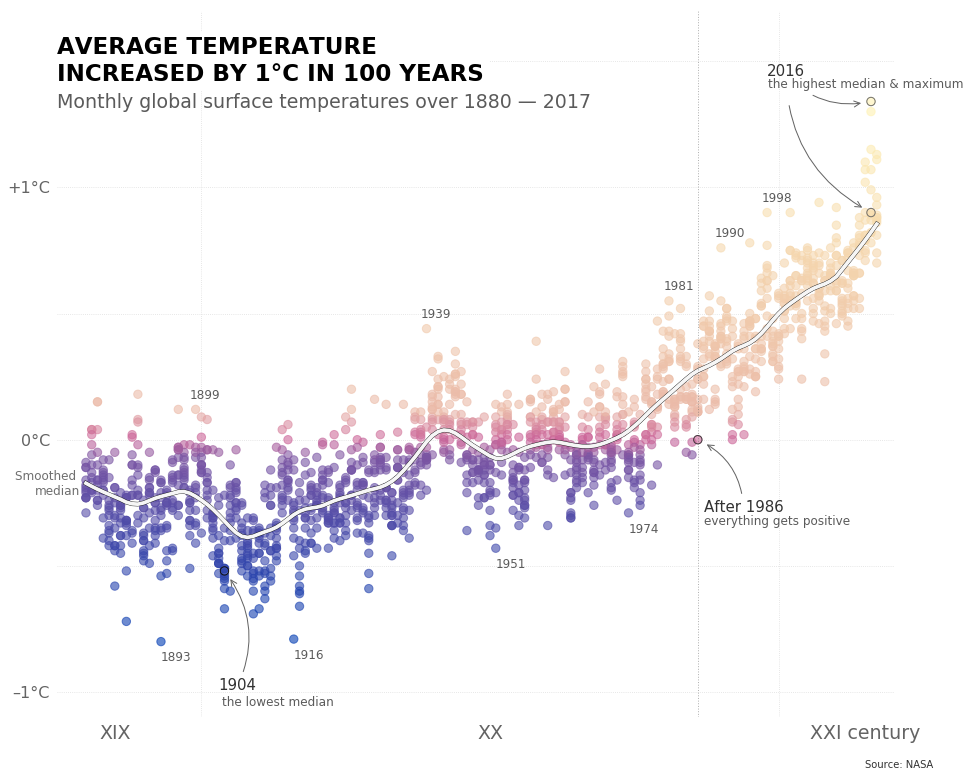

In [88]:
mpl.rcParams['figure.figsize'] = (15,13)
plt.rcParams['ytick.color'] = text_RGB
plt.rcParams['xtick.color'] = text_RGB
plt.rcParams['grid.color'] = grid_RGB
plt.rcParams['text.color'] = text2_RGB
plt.rcParams['font.size'] = 16

fig = plt.figure()
ax = fig.add_subplot(111)

years = [1885, 1950, 2015]
years_labels = ['XIX', 'XX', 'XXI century']
years_ticks = [1900, 2000]
degrees = np.round(np.linspace(-1, 1, 3), 1)
degrees_ticks = np.round(np.linspace(-1, 1.5, 6), 1)

ax.set_frame_on(False)
xlims = (1875, 2020)
ylims = (-1.1, 1.7)
ax.set_xlim(*xlims)
ax.set_ylim(*ylims)

ax.grid(which='minor', alpha=1, linestyle=':')
ax.grid(which='major', alpha=0)
ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none') 
formatter = mpl.ticker.FuncFormatter(lambda x, pos: '{}{:.0f}°C'\
                                     .format('+' if x>0 else ''if x==0 else'–',
                                             abs(x),
                                             'C' if x==1.2 else ''))
plt.gca().yaxis.set_major_formatter(formatter)
ax.set_xticks(years)
plt.xticks(years, years_labels, fontsize=19)
ax.set_xticks(years_ticks, minor=True)
ax.set_yticks(degrees)
ax.set_yticks(degrees_ticks, minor=True)

xs, ys, cs = [], [], []
for i, month in enumerate(months):
    xs.extend(df.Year)
    ys.extend(df[month])
    cs.extend(df_norm[month])
############ SCATTER PLOT ############
ax.scatter(xs, ys, s=70,
           c=cs, cmap=CustomCMap, alpha=0.6,
           zorder=2)
    

# Highlight local maxima
max_years_highlighted = [1899, 1939, 1981, 1990, 1998]
for year in max_years_highlighted:
    annotate(ax, year, (year, df.Max[year]), (year-1, df.Max[year]+0.03))
    
# Highlight local minima
min_years_highlighted = [1893, 1916, 1951, 1974]
for year in min_years_highlighted:
    annotate(ax, year, (year, df.Min[year]), (year, df.Min[year]-0.09))

# Average & min-max trend
t = np.arange(1,len(df.Year)+1)
frac = 0.12
trend_median = lowess(np.array(df['Median']), t, frac=frac, missing='drop', return_sorted=False)
ax.plot(df.Year, trend_median, color='k', linestyle='-', linewidth=4.5, alpha=0.92)
ax.plot(df.Year, trend_median, color='#FFFFFF', linestyle='-', linewidth=3.75, alpha=0.97)
trend_max = lowess(np.array(df['Max']), t, frac=frac, missing='drop', return_sorted=False)
trend_min = lowess(np.array(df['Min']), t, frac=frac, missing='drop', return_sorted=False)

# Annotations
annotate(ax, 'Smoothed \nmedian', (1879, -0.23),
         fontsize=12, alpha=0.7, align='right')

point = (1986, 0.0)
annotate_with_arrow(ax, 'After 1986', point, (1987, -0.3), 15)
annotate(ax, 'everything gets positive', (1987, -0.35))
ax.scatter(*point, s=70, color='None', edgecolors=text2_RGB, alpha=0.9, zorder=12)

point = (2016, df.Median[2016])
annotate_with_arrow(ax, '2016', point, (1998, 1.43), 15, 25)
ax.scatter(*point, s=70, color='None', edgecolors=text_RGB, alpha=0.9, zorder=12)
point = (2016, df.Max[2016])
annotate_with_arrow(ax, '       ', point, (1998, 1.43), 15, 25)
ax.scatter(*point, s=70, color='None', edgecolors=text_RGB, alpha=0.9, zorder=12)
annotate(ax, 'the highest median & maximum', (1998.1, 1.38))

point = (1904, df.Median[1904])
annotate_with_arrow(ax, '1904', point, (1903, -1.005), 15)
ax.scatter(*point, s=70, color='None', edgecolors='#101010', alpha=1, zorder=12)
annotate(ax, 'the lowest median', (1903.5, -1.065))

ax.vlines(1986, -1.1, 1.7, colors=text_RGB, linewidth=1, linestyle=':', zorder=100, alpha=0.5)

# Title
annotate_title(ax, 'Average temperature \nincreased by {:.0f}°C in 100 years'\
               .format(df.Median.iloc[-1] - df.Median.iloc[0]).upper(),
               (1875, 1.6), fontsize=23)
# Subtitle
annotate(ax, 'Monthly global surface temperatures over 1880 — 2017', (1875, 1.3), fontsize=19)
# Source
ax.text(2015, -1.3, 'Source: NASA', fontsize=10)

clr = mpl.colors.colorConverter.to_rgba(edge_RGB, alpha=0)

plt.savefig("vis.png", dpi=100)
plt.show()

Also using tips from the lecture I revisited the visualization and you can see the result above.